In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve

pd.set_option('display.max_columns', None)

In [32]:
df = pd.read_csv('data/dataset_meal.csv')
df.head(3)

,Age,Gender,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Workout_Type,Experience_Level,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,cluster_id,meal_name,C,P,M,ED,F
0,35,Male,188.58,157.65,69.05,1.00,Strength,2,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,2,Grilled Vegan Lunch,0.551030,0.342572,0.995365,0.258372,0.173291
1,23,Female,179.43,131.75,73.18,1.37,HIIT,2,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,2,Fried Vegetarian Lunch,0.481159,0.211067,0.998265,0.247696,0.471934
2,33,Female,175.04,123.95,54.96,0.91,Cardio,1,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,1,Boiled Paleo Breakfast,0.490618,0.604530,0.998705,0.082439,0.096575


In [33]:
user = pd.read_csv('data/new_user.csv')
user.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,Goal,WeightChange (kg),GoalDays,cluster_id,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout
0,22,Male,88.0,1.8,27.160494,2,3,3,Keto,Maintain,3.0,30,0,1900.0,1.725,3277.5,23100.0,11550.0,11550.0,3277.5,12.857143,898.333333


In [34]:
goal = user['Goal'].iloc[0]

if goal == 'Loss':
    df['target'] = 0.35*df['C'] + 0.25*df['P'] + 0.15*df['M'] + 0.15*df['ED'] + 0.1*df['F']
elif goal == 'Maintain':
    df['target'] = 0.3*df['C'] + 0.25*df['M'] + 0.2*df['P'] + 0.1*df['ED'] + 0.15*df['F']
elif goal == 'Gain':
    df['target'] = 0.4*df['C'] + 0.3*df['P'] + 0.15*df['M'] + 0.1*df['ED'] + 0.05*df['F']
else:
    raise ValueError("Goal must be one of: 'Loss', 'Maintain', 'Gain'")

### Training dataset preparation

In [35]:
df = df.drop(columns=['C', 'P', 'M', 'ED', 'F'])
df.head(3)

,Age,Gender,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Workout_Type,Experience_Level,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,cluster_id,meal_name,target
0,35,Male,188.58,157.65,69.05,1.00,Strength,2,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,2,Grilled Vegan Lunch,0.534495
1,23,Female,179.43,131.75,73.18,1.37,HIIT,2,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,2,Fried Vegetarian Lunch,0.531687
2,33,Female,175.04,123.95,54.96,0.91,Cardio,1,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,1,Boiled Paleo Breakfast,0.540498


In [36]:
# 3) Split X/y
X = df.drop(columns=['target'])
y = df['target']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [37]:
numerical_features = ['Age', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'rating', 'Sets', 'Reps', 'Burns Calories (per 30 min)']

categorical_features = ['Gender', 'Workout_Type', 'Experience_Level', 'Name of Exercise', 'Benefit', 
       'Target Muscle Group', 'Equipment Needed', 'Difficulty Level', 'Body Part', 'Type of Muscle',
       'Workout', 'cluster_id', 'meal_name']

In [38]:
# 4) One-hot encoding (fit on train only, transform val/test)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc   = preprocess.transform(X_val)
X_test_enc  = preprocess.transform(X_test)

### Baseline model: Linear Regression

In [39]:
lr = LinearRegression()
lr.fit(X_train_enc, y_train)
val_pred_lr = lr.predict(X_val_enc)

rmse_lr = np.sqrt(mean_squared_error(y_val, val_pred_lr))

print(f"Validation RMSE (Linear Regression): {rmse_lr:.7f}")

Validation RMSE (Linear Regression): 0.0620331


### Main model: XGBoost

In [40]:
# --------------------------------------------------
# Manual selection of n_estimators using VALIDATION
# --------------------------------------------------

n_estimators_list = [50, 100, 200, 300, 500]
results = []

for n in n_estimators_list:
    model = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    
    model.fit(X_train_enc, y_train)
    val_pred = model.predict(X_val_enc)
    
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    results.append((n, rmse))

# --------------------------------------------------
# Select best n_estimators
# --------------------------------------------------

best_n, best_rmse = min(results, key=lambda x: x[1])
print(f"Best n_estimators: {best_n}")
print(f"Validation RMSE: {best_rmse:.4f}")

# --------------------------------------------------
# Train FINAL model on training data
# --------------------------------------------------

final_model = XGBRegressor(
    n_estimators=best_n,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

final_model.fit(X_train_enc, y_train);  


Best n_estimators: 500
Validation RMSE: 0.0264


In [41]:
test_pred = final_model.predict(X_test_enc)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.0256


### Hyperparameter tuning

In [42]:
# Base model (we keep objective fixed for regression)
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Parameter search space (covers the big knobs)
param_distributions = {
    "n_estimators": [100, 200, 300, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "min_child_weight": [1, 2, 5, 10],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5, 1.0],
    "reg_alpha": [0, 1e-4, 1e-3, 1e-2, 0.1, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}

# Use neg MSE for max compatibility with older sklearn,
# then we take sqrt later for RMSE.
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,                 # increase to 80+ if you can afford time
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_enc, y_train)

print("Best CV params:", search.best_params_)
print("Best CV RMSE:", np.sqrt(-search.best_score_))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV params: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.08, 'gamma': 0, 'colsample_bytree': 0.9}
Best CV RMSE: 0.014595023129080894


In [43]:
best_model = search.best_estimator_

val_pred = best_model.predict(X_val_enc)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"Validation RMSE after tuning: {val_rmse:.6f}")

Validation RMSE after tuning: 0.013646


In [44]:
test_pred = best_model.predict(X_test_enc)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE: {test_rmse:.6f}")

Test RMSE: 0.013476


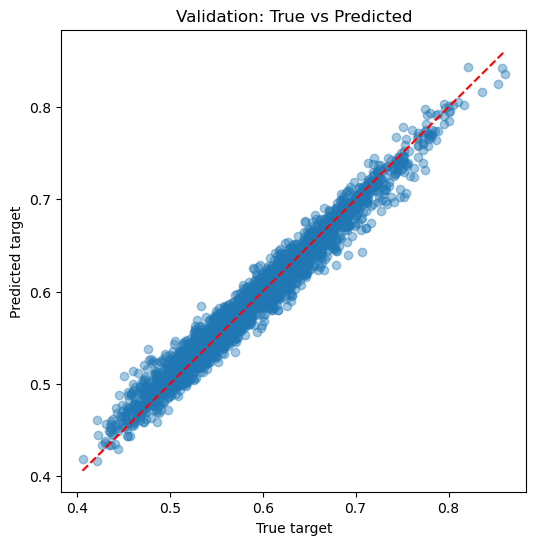

In [45]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_pred, alpha=0.4)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.title("Validation: True vs Predicted")
plt.show()


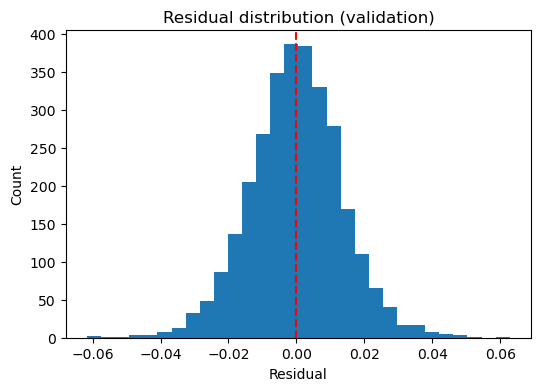

In [46]:
residuals = y_val - val_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual distribution (validation)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


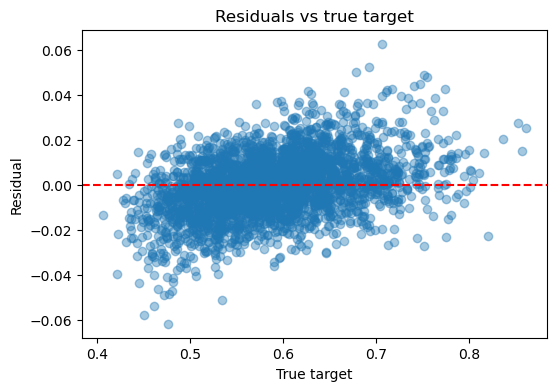

In [47]:
plt.figure(figsize=(6,4))
plt.scatter(y_val, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True target")
plt.ylabel("Residual")
plt.title("Residuals vs true target")
plt.show()

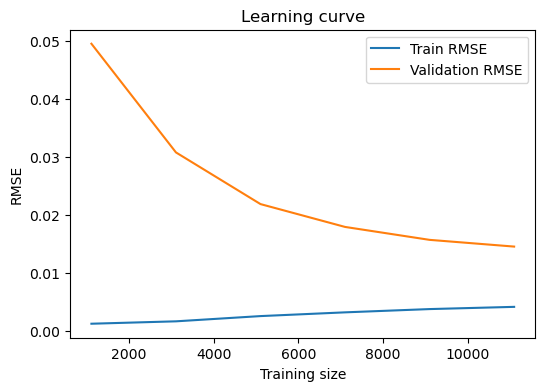

In [48]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_enc,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6)
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_rmse, label="Train RMSE")
plt.plot(train_sizes, val_rmse, label="Validation RMSE")
plt.xlabel("Training size")
plt.ylabel("RMSE")
plt.title("Learning curve")
plt.legend()
plt.show()


#### Save the model and encoder

In [49]:
import joblib

joblib.dump(preprocess, "encoder.pkl")
joblib.dump(final_model, "models/meal_model.pkl")
print("Saved the meal model!")

Saved the meal model!


Exception ignored in: <function ResourceTracker.__del__ at 0x103de9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102ebdbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107ee9bc0>
Traceback (most recent call last